In [1]:
import numpy as np, pickle, matplotlib, pathlib
import matplotlib.pyplot as plt, os
%matplotlib inline
from astropy.table import Table, vstack
from tqdm import trange
from SomLib import SelfOrgMap
import pyarrow.feather as ft
import pyarrow as pa
import pyarrow.compute as pc
import pandas as pd
import pyarrow.parquet as pq

## Calculate Distance Matrix

In [2]:

x_size = 30            ## x size for SOM
y_size = 60             ## y size for SOM
boundary = 'Periodic'   ## boundary condition for SOM; 'Periodic' or 'Dirichlet'


In [3]:
## make a folder for distance matrix
pathlib.Path('./distLib').mkdir(parents=True, exist_ok=True) 

## run dist_lib.py to create distance matrix
!python dist_lib.py {x_size} {y_size} {boundary}

number of pixels:  1800
calculating distance library: 0 / 1800
calculating distance library: 100 / 1800
calculating distance library: 200 / 1800
calculating distance library: 300 / 1800
calculating distance library: 400 / 1800
calculating distance library: 500 / 1800
calculating distance library: 600 / 1800
calculating distance library: 700 / 1800
calculating distance library: 800 / 1800
Distance Matrix saved as: ./distLib/distLib30x60_Periodic.fits


## Define the SOM

In [4]:
data_keys = ['ug', 'gr', 'ri', 'iz', 'zy', 'i']
dim = len(data_keys)

som = SelfOrgMap(MapDim=2, x=x_size, y=y_size, boundary=boundary, data_keys=data_keys, Path_distLib='./distLib/')
som.info()


Map Dimension: 2
Map Size: 30x60
Number of SOM cells: 1800
Boundary Condition: Periodic
Dimension of SOM weight vectors: (1800, 6)
Feature Distance Metric (Euc/Chi2): Euclidean
Initial Weights: self.iw

SOM not trained


## Look at the initial map

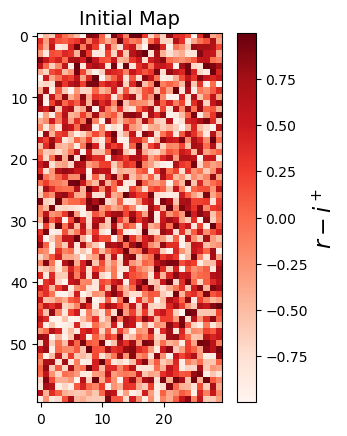

In [5]:
c = 'ri'
ind = data_keys.index(c)

map_data = som.w[:,ind]  ## initial cell weights, looking at the r-ip component
map_data_2d = som.get_2d_map(map_data)

plt.imshow(map_data_2d.T, cmap='Reds')

fig = plt.gcf()
ax = plt.gca()
img = ax.get_images()[0]
ax.set_title('Initial Map', fontsize=14)
cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=1.0, pad=0.03)
cbar.set_label(label=r'$r - i^+$', size=16)

## Look at Training Data

In [6]:
data = pd.read_parquet('10050.parquet')

In [7]:
print(list(data.columns))

['redshift', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y', 'zp_u', 'zp_g', 'zp_r', 'zp_i', 'zp_z', 'zp_y', 'alpha', 'base_wavelength', 'zenith_angle', 'parallactic_angle', 'psf_seeing_moment_ratio_u', 'psf_seeing_moment_ratio_g', 'psf_seeing_moment_ratio_r', 'psf_seeing_moment_ratio_i', 'psf_seeing_moment_ratio_z', 'psf_seeing_moment_ratio_y', 'psf_dcr_shifts_first_u', 'psf_dcr_shifts_first_g', 'psf_dcr_shifts_first_r', 'psf_dcr_shifts_first_i', 'psf_dcr_shifts_first_z', 'psf_dcr_shifts_first_y', 'psf_dcr_shifts_second_u', 'psf_dcr_shifts_second_g', 'psf_dcr_shifts_second_r', 'psf_dcr_shifts_second_i', 'psf_dcr_shifts_second_z', 'psf_dcr_shifts_second_y']


In [8]:
columns = data.dtypes
print(columns)

redshift                     float64
mag_u                        float64
mag_g                        float64
mag_r                        float64
mag_i                        float64
mag_z                        float64
mag_y                        float64
zp_u                         float64
zp_g                         float64
zp_r                         float64
zp_i                         float64
zp_z                         float64
zp_y                         float64
alpha                        float64
base_wavelength              float64
zenith_angle                 float64
parallactic_angle            float64
psf_seeing_moment_ratio_u    float64
psf_seeing_moment_ratio_g    float64
psf_seeing_moment_ratio_r    float64
psf_seeing_moment_ratio_i    float64
psf_seeing_moment_ratio_z    float64
psf_seeing_moment_ratio_y    float64
psf_dcr_shifts_first_u        object
psf_dcr_shifts_first_g        object
psf_dcr_shifts_first_r        object
psf_dcr_shifts_first_i        object
p

In [9]:
len(data)

1024433

In [10]:
train = data.sample(frac = 0.05)
vali = data.drop(train.index)

In [11]:
print(len(train))
print(len(vali))

51222
973211


Random indices -- still split it as 0 to 2000 and the rest

rng.choice

- make a mask of ones of the length of the data set
    - bools
- choose some random indices using np.random.randomint, without replacement
- pass the indices into the mask and flip from 1 to 0
    - strongly advise against a for loop, takes too long
- if they are 0 they go into train
- if they are 1 they go into vali

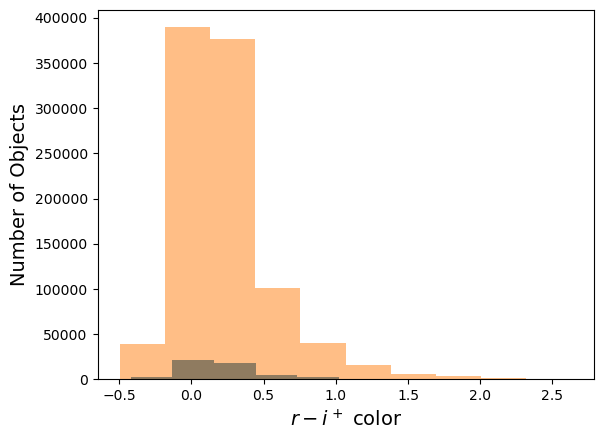

In [12]:
plt.hist(train['mag_u'] -  train['mag_g'])
plt.hist(vali['mag_u'] -  vali['mag_g'], alpha = 0.5)

plt.xlabel(r'$r - i^+$ color', fontsize=14)
plt.ylabel(r'Number of Objects', fontsize=14)

plt.show()

## Calculate Colors from magnitudes; Scale Features to average at 0 with std=1

In [13]:
def prep_data(cat, num_att, data_keys, data_dict, ave=None, std=None):

    data = np.zeros((len(cat), num_att))

    for i, key in enumerate(data_keys):

        if len(data_dict[key])==2:    ## if the feature is a color = mag1 - mag2
            mag1, mag2 = data_dict[key]
            data[:,i] = cat[mag1] - cat[mag2]

        elif len(data_dict[key])==1:  ## if the feature involves only 1 column: magnitude, size/shape, or a color column pre-calculated elsewhere
            mag, = data_dict[key]
            data[:,i] = cat[mag]

    ## re-scale the data to center on 0 with std of 1 ##

    if (ave is None) or (std is None):

        ave = data.mean(axis=0)
        std = data.std(axis=0, ddof=1)

        for i in range(num_att):
            data[:,i] = (data[:,i] - ave[i]) / std[i]

        return data, ave, std
    
    else:
        
        for i in range(num_att):
            data[:,i] = (data[:,i] - ave[i]) / std[i]

        return data

In [14]:
data_keys = ['ug', 'gr', 'ri', 'iz', 'zy', 'i']
data_dict = {'ug':['mag_u','mag_g'], 'gr':['mag_g','mag_r'], 'ri':['mag_r','mag_i'], 'iz':['mag_i','mag_z'], \
             'zy':['mag_z','mag_y'], 'i':['mag_i']}

num_att = len(data_keys)

train_data, train_ave, train_std = prep_data(train, num_att, data_keys, data_dict)

train_var = np.zeros(train_data.shape)
train_mask = np.ones(train_data.shape)

vali_data, vali_ave, vali_std = prep_data(vali, num_att, data_keys, data_dict)

vali_var = np.zeros(vali_data.shape)
vali_mask = np.ones(vali_data.shape)



In [15]:
print(train_ave)    ## average of features; subtracted out to center on 0
print(train_std)    ## std of features; divided by it for an std=1

[ 0.24388009  0.39287917  0.41680658  0.29432849  0.21124581 24.43031142]
[0.32208903 0.33716905 0.25917821 0.19784273 0.16607352 1.45317069]


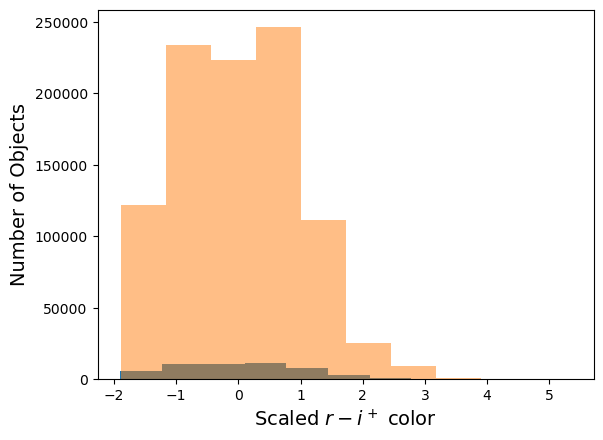

std of scaled r-ip color: 0.9999902385217231


In [16]:
c = 'ri'
ind = data_keys.index(c)

plt.hist(train_data[:,ind])
plt.hist(vali_data[:,ind], alpha = 0.5)
plt.xlabel(r'Scaled $r - i^+$ color', fontsize=14)
plt.ylabel(r'Number of Objects', fontsize=14)

plt.show()

print(r'std of scaled r-ip color:', train_data[:,ind].std())

## Train the SOM

In [17]:
path = 'run1/'
pathlib.Path(path).mkdir(parents=True, exist_ok=True) 

In [18]:
if 1:
    
    iter_steps = [0, 100, 1000, 10000, 25000, 51221]
    som.train_SOM(train_data, train_var, train_mask, save_iter=iter_steps)
    som.unscale_weights(train_ave, train_std)
    
    with open(path + f'som_T.pkl', 'wb') as output:  ## T for training
        pickle.dump(som, output, pickle.HIGHEST_PROTOCOL)
        
else:
    
    with open(path + f'som_T.pkl', 'rb') as input:
        som = pickle.load(input)

Training the SOM:


100%|██████████| 51222/51222 [00:20<00:00, 2530.72it/s]


In [19]:
som.info()

Map Dimension: 2
Map Size: 30x60
Number of SOM cells: 1800
Boundary Condition: Periodic
Dimension of SOM weight vectors: (1800, 6)
Feature Distance Metric (Euc/Chi2): Euclidean
Initial Weights: self.iw

Data Sets mapped onto SOM: ['training']
Trained Weights: self.w
Un-Scaled Weights: self.uw


## Intermediate SOM

In [20]:
print(som.w_at_iter)

{0: array([[ 0.63633211,  0.57017249, -0.90599794, -0.4200042 , -0.41465292,
        -0.48029072],
       [ 0.34783873,  0.65829879, -0.47385292,  0.34647576, -0.21408354,
        -0.73555322],
       [-0.01669864,  0.35600153, -0.62867032, -0.45944238, -0.94616187,
        -0.95383193],
       ...,
       [ 0.86114239, -0.54069537, -0.62298993,  0.02131641,  0.30420244,
         0.1042468 ],
       [ 0.98463669,  0.05072065, -0.60371938,  0.29007485,  0.40655395,
         0.17466904],
       [ 0.19226531, -0.20302672, -0.33428707, -0.64884011,  0.17048407,
        -0.49234844]]), 100: array([[-0.86753208, -0.85621379, -1.26738055, -0.58609757,  0.06035976,
         0.91330672],
       [-0.88206533, -0.87004127, -1.27925457, -0.59899453,  0.04626426,
         0.91676297],
       [-0.89583381, -0.88350446, -1.29046245, -0.61128079,  0.03330254,
         0.91963699],
       ...,
       [-0.9336386 , -0.9274003 , -1.31426529, -0.63397986,  0.02833985,
         0.9353119 ],
       [-0.9186

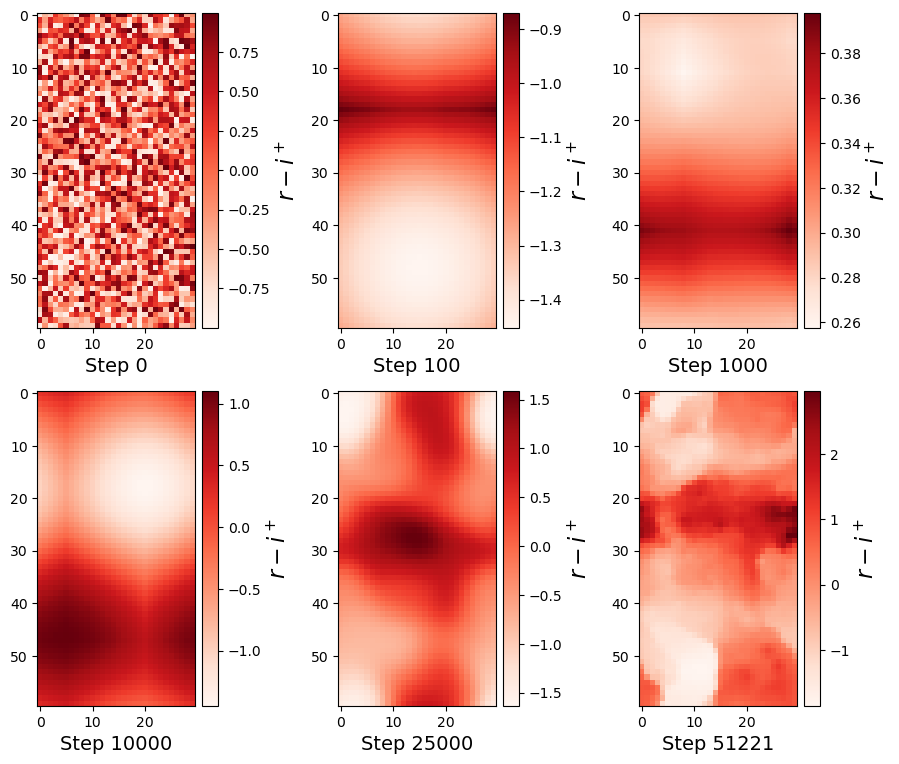

In [21]:
c = 'ri'
ind = data_keys.index(c)

fig, axes = plt.subplots(2,3, figsize=(11,9))

for ax, step in zip(axes.flatten(), iter_steps):

    map_data = som.w_at_iter[step][:,ind]
    map_data_2d = som.get_2d_map(map_data)

    ax.imshow(map_data_2d.T, cmap='Reds')
    ax.set_xlabel(f'Step {step}', fontsize=14)

    img = ax.get_images()[0]
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=1.0, pad=0.03)
    cbar.set_label(label=r'$r - i^+$', size=16)

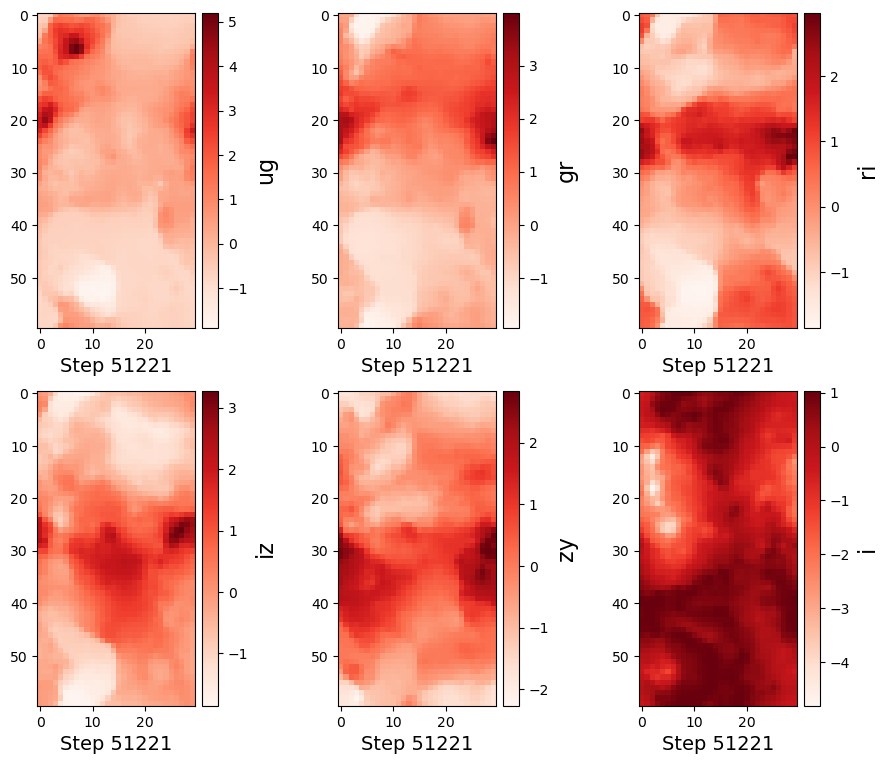

In [22]:
# Final iteration for all colors and i-band.

fig, axes = plt.subplots(2,3, figsize=(11,9))

for ax, index in zip(axes.flatten(), data_keys):
    map_data = som.w_at_iter[51221][:,data_keys.index(index)]
    map_data_2d = som.get_2d_map(map_data)

    ax.imshow(map_data_2d.T, cmap='Reds')
    ax.set_xlabel(f'Step {step}', fontsize=14)

    img = ax.get_images()[0]
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=1.0, pad=0.03)
    cbar.set_label(label=str(index), size=16)

## Map the data set: some other galaxies

In [23]:
if 1:
    
    bmu_ind, bmu_dist = som.map_objects(data_keys, vali_data, vali_var, vali_mask,\
                                      data_name='vali_pure')
    
    vali['bmu_ind'] = bmu_ind
    vali['bmu_dist'] = bmu_dist
    
    vali.to_parquet(path + f'vali_pure_mapped.pk')
    with open(path + f'som_TV.pkl', 'wb') as output:  ## T for training, V for validation
        pickle.dump(som, output, pickle.HIGHEST_PROTOCOL)

else:
    
    train = Table.read(path + f'vali_pure_mapped.fits', format='fits')
    with open(path + f'som_TV.pkl', 'rb') as input:
        som = pickle.load(input)

Mapping Objects onto SOM


100%|██████████| 973211/973211 [03:02<00:00, 5330.64it/s]


In [24]:
som.info()

Map Dimension: 2
Map Size: 30x60
Number of SOM cells: 1800
Boundary Condition: Periodic
Dimension of SOM weight vectors: (1800, 6)
Feature Distance Metric (Euc/Chi2): Euclidean
Initial Weights: self.iw

Data Sets mapped onto SOM: ['training', 'vali_pure']
Trained Weights: self.w
Un-Scaled Weights: self.uw


## Calculate SOMz

In [25]:
if 1:
    
    som.calc_SOMz(np.array(vali['redshift']), data_name='vali_pure')
    with open(path + f'som_TVZ.pkl', 'wb') as output:  ## Z for SOMz
        pickle.dump(som, output, pickle.HIGHEST_PROTOCOL)
else:
    
    with open(path + f'som_TVZ.pkl', 'rb') as input:
        som = pickle.load(input)

100%|██████████| 1800/1800 [00:00<00:00, 8627.93it/s]
/Users/jonathan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jonathan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jonathan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jonathan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jonathan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Calculate in-cell Average of Features

In [26]:
psf_seeing_moment_ratio_u_ave, psf_seeing_moment_ratio_u_err = som.cell_average(np.array(vali['psf_seeing_moment_ratio_u']), data_name='vali_pure')
psf_seeing_moment_ratio_g_ave, psf_seeing_moment_ratio_g_err = som.cell_average(np.array(vali['psf_seeing_moment_ratio_g']), data_name='vali_pure')
psf_seeing_moment_ratio_r_ave, psf_seeing_moment_ratio_r_err = som.cell_average(np.array(vali['psf_seeing_moment_ratio_r']), data_name='vali_pure')
psf_seeing_moment_ratio_i_ave, psf_seeing_moment_ratio_i_err = som.cell_average(np.array(vali['psf_seeing_moment_ratio_i']), data_name='vali_pure')
psf_seeing_moment_ratio_z_ave, psf_seeing_moment_ratio_z_err = som.cell_average(np.array(vali['psf_seeing_moment_ratio_z']), data_name='vali_pure')
psf_seeing_moment_ratio_y_ave, psf_seeing_moment_ratio_y_err = som.cell_average(np.array(vali['psf_seeing_moment_ratio_y']), data_name='vali_pure')

100%|██████████| 1800/1800 [00:00<00:00, 15009.89it/s]


## Make Plots

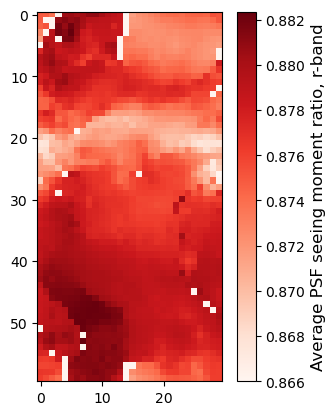

In [27]:
map_data_2d_r = som.get_2d_map(psf_seeing_moment_ratio_r_ave)

plt.imshow(map_data_2d_r.T, cmap='Reds', vmin = 0.866)

fig = plt.gcf()
ax = plt.gca()
img = ax.get_images()[0]
cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=1.0, pad=0.03)
cbar.set_label(label=r'Average PSF seeing moment ratio, r-band', size=12)


In [28]:
sum(i > 10**(-3) for i in psf_seeing_moment_ratio_r_err)

1

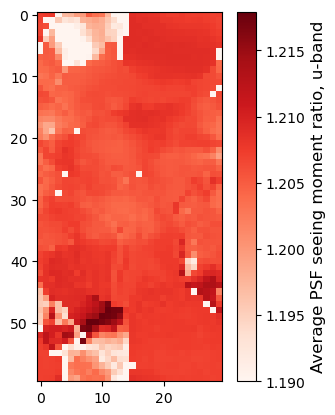

In [29]:
map_data_2d_u = som.get_2d_map(psf_seeing_moment_ratio_u_ave)

plt.imshow(map_data_2d_u.T, cmap='Reds', vmin = 1.19)

fig = plt.gcf()
ax = plt.gca()
img = ax.get_images()[0]
cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=1.0, pad=0.03)
cbar.set_label(label=r'Average PSF seeing moment ratio, u-band', size=12)


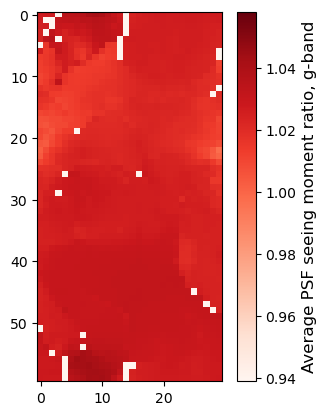

In [30]:
map_data_2d_g = som.get_2d_map(psf_seeing_moment_ratio_g_ave)

plt.imshow(map_data_2d_g.T, cmap='Reds', vmin = 1.058)

fig = plt.gcf()
ax = plt.gca()
img = ax.get_images()[0]
cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=1.0, pad=0.03)
cbar.set_label(label=r'Average PSF seeing moment ratio, g-band', size=12)


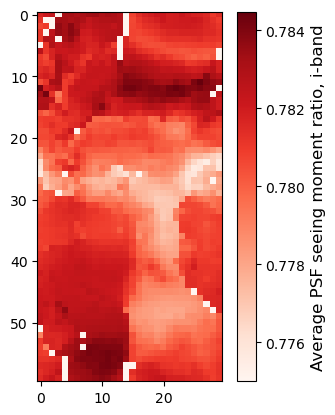

In [31]:
map_data_2d_i = som.get_2d_map(psf_seeing_moment_ratio_i_ave)

plt.imshow(map_data_2d_i.T, cmap='Reds', vmin = 0.775)

fig = plt.gcf()
ax = plt.gca()
img = ax.get_images()[0]
cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=1.0, pad=0.03)
cbar.set_label(label=r'Average PSF seeing moment ratio, i-band', size=12)


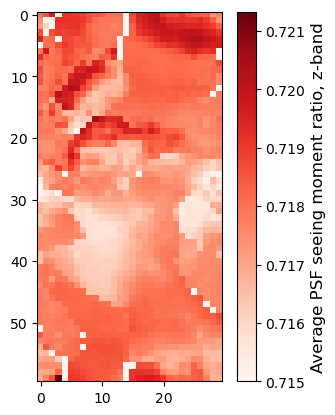

In [32]:
map_data_2d_z = som.get_2d_map(psf_seeing_moment_ratio_z_ave)

plt.imshow(map_data_2d_z.T, cmap='Reds', vmin = 0.715)

fig = plt.gcf()
ax = plt.gca()
img = ax.get_images()[0]
cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=1.0, pad=0.03)
cbar.set_label(label=r'Average PSF seeing moment ratio, z-band', size=12)


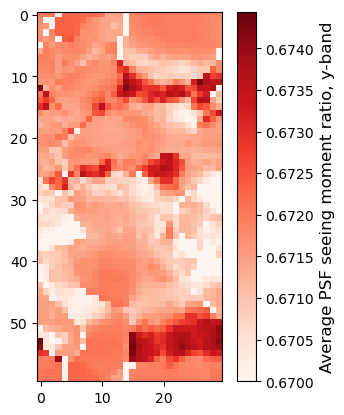

In [33]:
map_data_2d_y = som.get_2d_map(psf_seeing_moment_ratio_y_ave)

plt.imshow(map_data_2d_y.T, cmap='Reds', vmin = 0.67)

fig = plt.gcf()
ax = plt.gca()
img = ax.get_images()[0]
cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=1.0, pad=0.03)
cbar.set_label(label=r'Average PSF seeing moment ratio, y-band', size=12)


In [34]:
print(map_data_2d_u)
print(map_data_2d_g)
print(map_data_2d_r)
print(map_data_2d_i)
print(map_data_2d_z)
print(map_data_2d_y)


[[ 1.20721003  1.20681235  1.20653094 ...  1.20702169  1.20702641
   1.20708486]
 [ 1.20736344 -1.          1.20593356 ...  1.2069615   1.20702858
   1.20716034]
 [ 1.20777367 -1.         -1.         ...  1.20705558  1.20708496
   1.20731605]
 ...
 [ 1.20719156  1.20731128  1.20771525 ...  1.2070038   1.20688355
   1.20702611]
 [ 1.20695607  1.20708944  1.2074035  ...  1.20702665  1.20706326
   1.20699055]
 [ 1.20702171  1.20679554  1.20688853 ...  1.2069562   1.20701483
   1.20709683]]
[[ 1.02700612  1.02631107  1.0254696  ...  1.02742675  1.02801542
   1.02804334]
 [ 1.02714189 -1.          1.02628247 ...  1.02742141  1.02811607
   1.02768351]
 [ 1.02688669 -1.         -1.         ...  1.02766821  1.02829746
   1.02749   ]
 ...
 [ 1.02619826  1.0256661   1.02511888 ...  1.02698239  1.02687396
   1.02653226]
 [ 1.02661584  1.02549033  1.02489142 ...  1.02754508  1.02762844
   1.02752515]
 [ 1.0267627   1.02616894  1.02471336 ...  1.02757597  1.02770096
   1.02780102]]
[[ 0.87483479  0

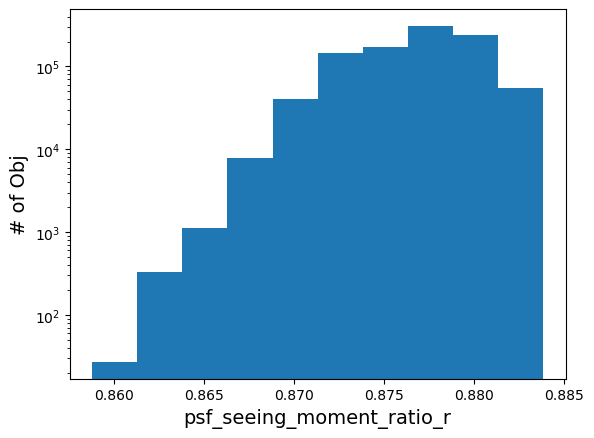

In [35]:
plt.hist(vali['psf_seeing_moment_ratio_r'])
plt.yscale('log')
plt.xlabel('psf_seeing_moment_ratio_r', fontsize=14)
plt.ylabel('# of Obj', fontsize=14)

plt.show()


In [36]:
data_keys

['ug', 'gr', 'ri', 'iz', 'zy', 'i']

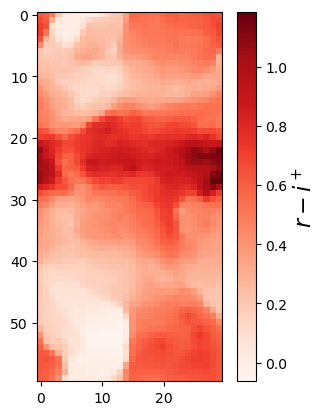

In [37]:
c = 'ri'
ind = data_keys.index(c)

map_data = som.uw[:,ind]
map_data_2d = som.get_2d_map(map_data)

plt.imshow(map_data_2d.T, cmap='Reds')

fig = plt.gcf()
ax = plt.gca()
img = ax.get_images()[0]
cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=1.0, pad=0.03)
cbar.set_label(label=r'$r - i^+$', size=16)


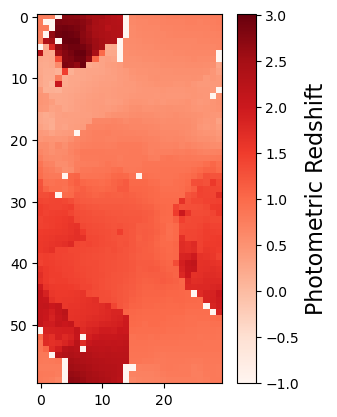

In [38]:

map_data = som.somz['vali_pure']
map_data_2d = som.get_2d_map(map_data)

plt.imshow(map_data_2d.T, cmap='Reds')

fig = plt.gcf()
ax = plt.gca()
img = ax.get_images()[0]
cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=1.0, pad=0.03)
cbar.set_label(label=r'Photometric Redshift', size=16)


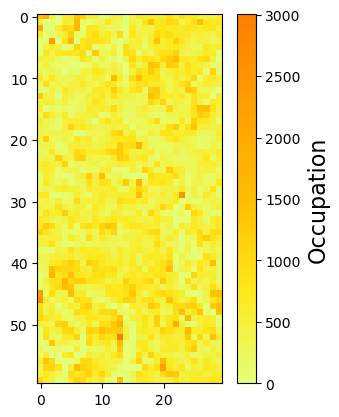

In [39]:
map_data = som.occ['vali_pure']
map_data_2d = som.get_2d_map(map_data)

plt.imshow(map_data_2d.T, cmap='Wistia')

fig = plt.gcf()
ax = plt.gca()
img = ax.get_images()[0]
cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=1.0, pad=0.03)
cbar.set_label(label=r'Occupation', size=16)


In [40]:
%matplotlib tk

map_data = som.occ['vali_pure']
map_data_2d = som.get_2d_map(map_data)


som.click_cell(map_data_2d.T)

In [41]:
cell_inds = som.get_click_ind()


Call click_cell to click on the map first


In [42]:
cell_inds


0